
WINEQUALITY-RED

      fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1594            6.2             0.600         0.08             2.0      0.090   
1595            5.9             0.550         0.10             2.2      0.062   
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645         0.12             2.0      0.075   
1598            6.0             0.310         0.47             3.6      0.067   

      fre

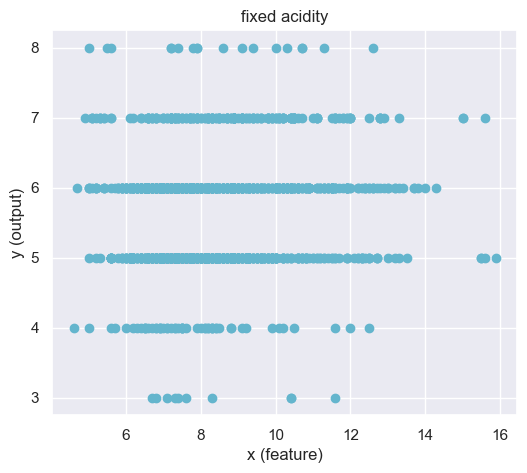

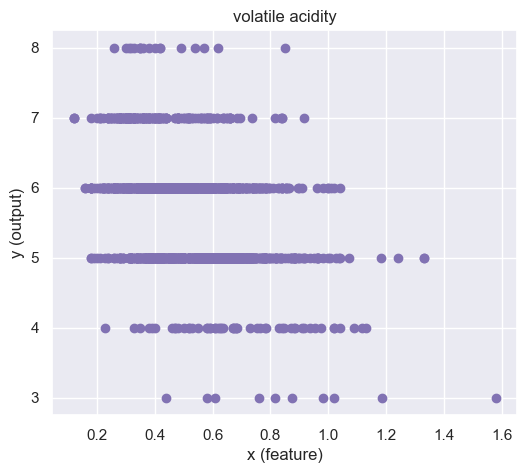

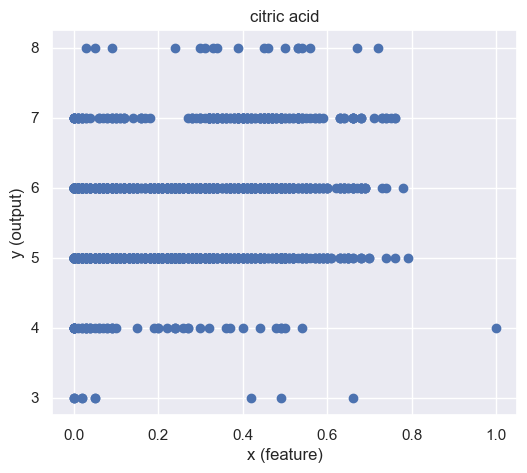

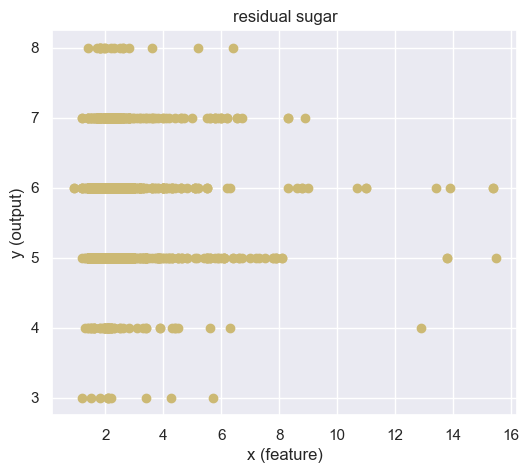

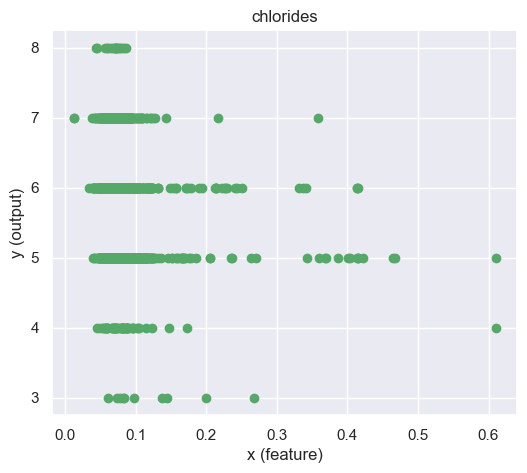

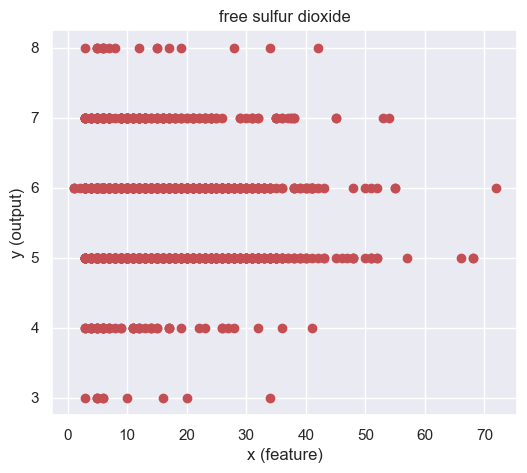

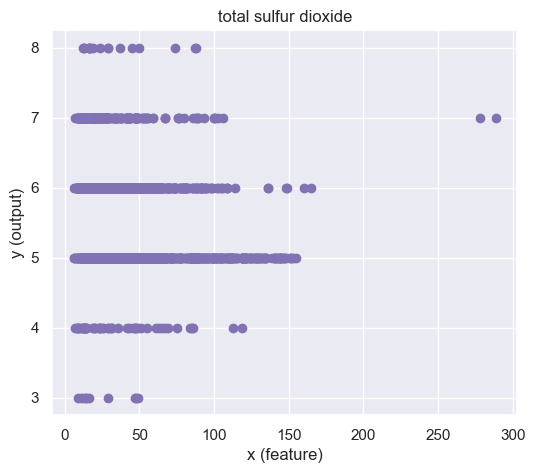

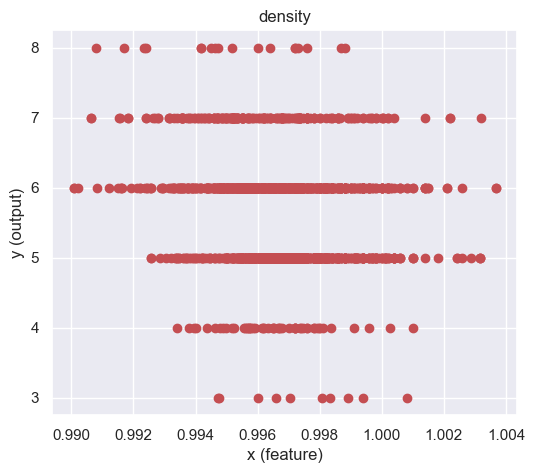

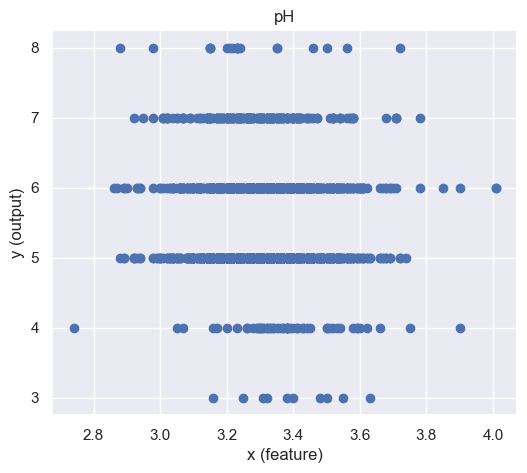

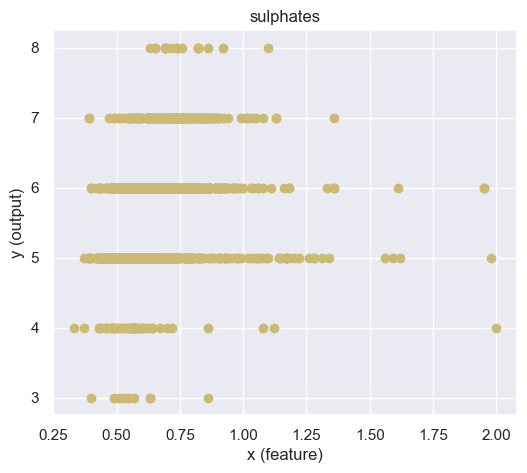

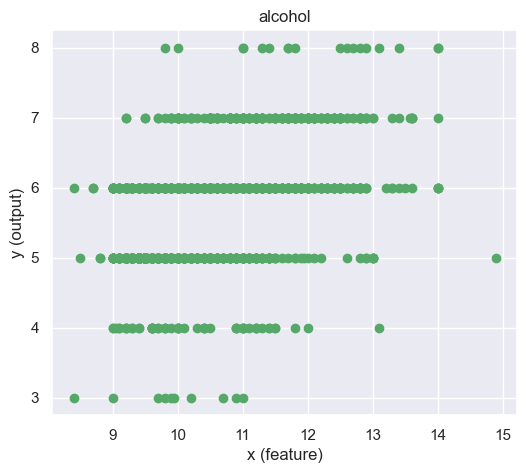

ROOT
Root
   | Prediction: 5.664
   | RSS: 0.66
   | Number of nodes: 1279
@** Condition: alcohol <= 10.55
     | Prediction: 5.387
     | RSS: 0.41
     | Number of nodes: 804
@***** Condition: sulphates <= 0.575
        | Prediction: 5.172
        | RSS: 0.31
        | Number of nodes: 303
@******** Condition: density <= 1.001
           | Prediction: 5.179
           | RSS: 0.29
           | Number of nodes: 302
@*********** Condition: alcohol <= 9.75
              | Prediction: 5.1
              | RSS: 0.21
              | Number of nodes: 210
@************** Condition: pH <= 3.54
                 | Prediction: 5.087
                 | RSS: 0.2
                 | Number of nodes: 207
@**************** Condition: density <= 0.997
                   | Prediction: 5.171
                   | RSS: 0.23
                   | Number of nodes: 111
@******************* Condition: sulphates <= 0.525
                      | Prediction: 5.037
                      | RSS: 0.18
                  

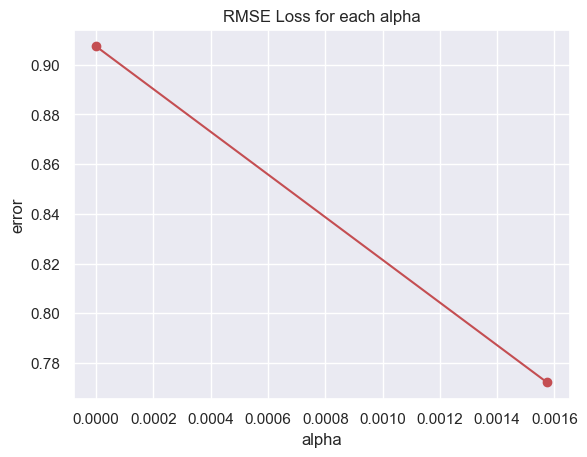

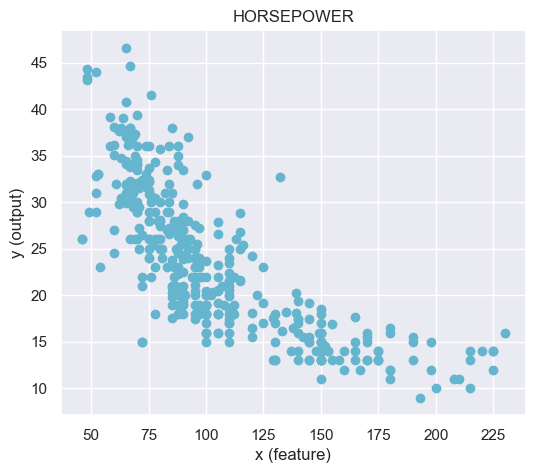

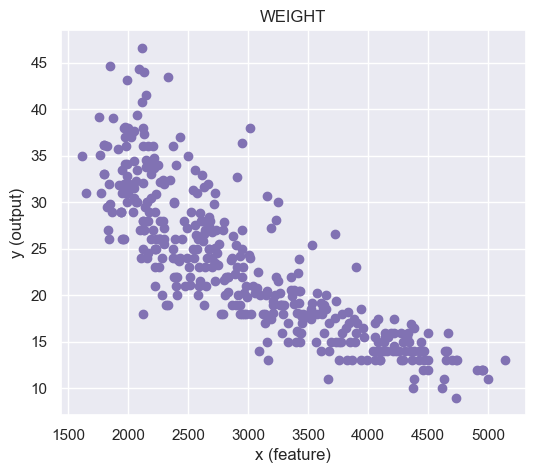

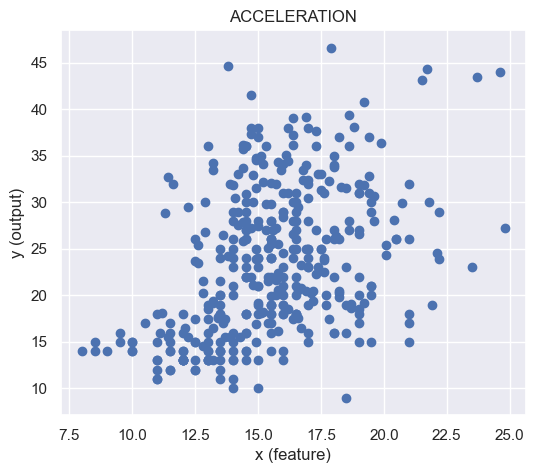

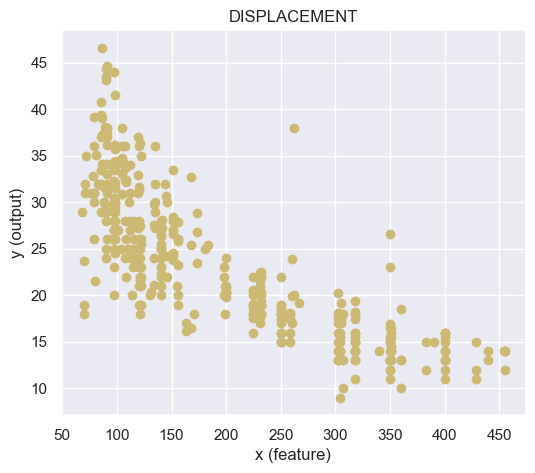

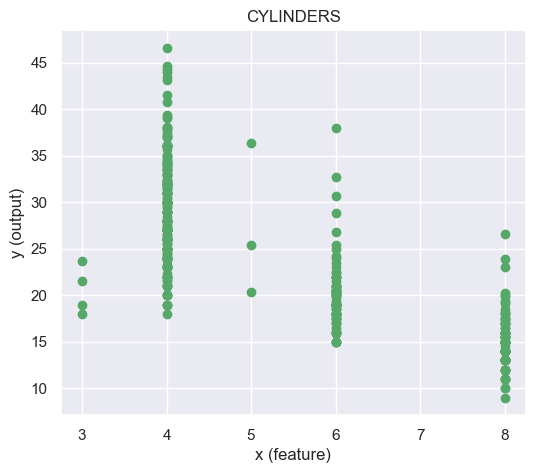

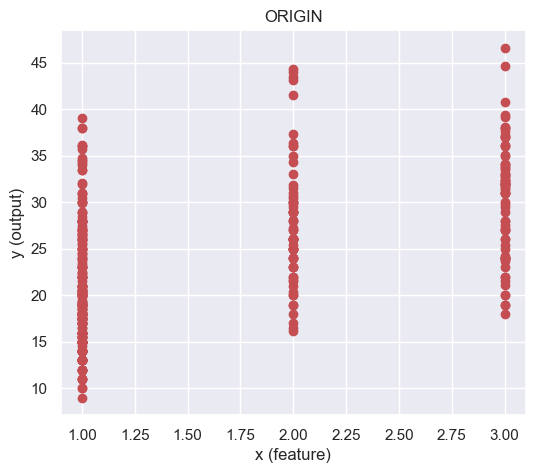

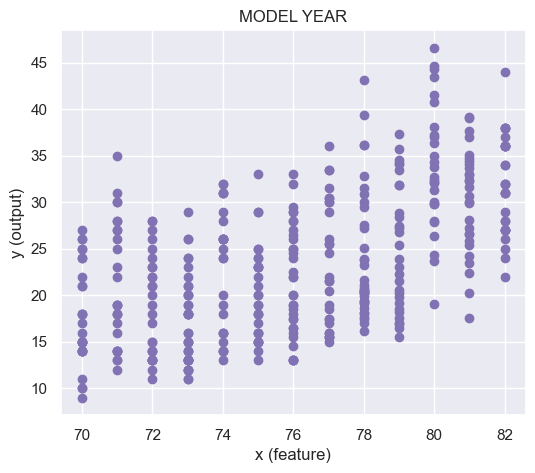

ROOT
Root
   | Prediction: 21.33
   | RSS: 44.74
   | Number of nodes: 313
@** Condition: weight <= 2764.5
     | Prediction: 27.524
     | RSS: 23.9
     | Number of nodes: 132
@***** Condition: weight <= 2219.5
        | Prediction: 30.733
        | RSS: 18.98
        | Number of nodes: 66
@******** Condition: model_year == 77.0
           | Prediction: 31.611
           | RSS: 4.54
           | Number of nodes: 9
@*********** Condition: displacement <= 91.0
              | Prediction: 34.75
              | RSS: 1.56
              | Number of nodes: 2
@*********** Condition: displacement > 91.0
              | Prediction: 30.714
              | RSS: 1.78
              | Number of nodes: 7
@************** Condition: horsepower <= 81.5
                 | Prediction: 30.25
                 | RSS: 0.56
                 | Number of nodes: 6
@**************** Condition: weight <= 1962.5
                   | Prediction: 29.0
                   | RSS: 0.0
                   | Number of nodes

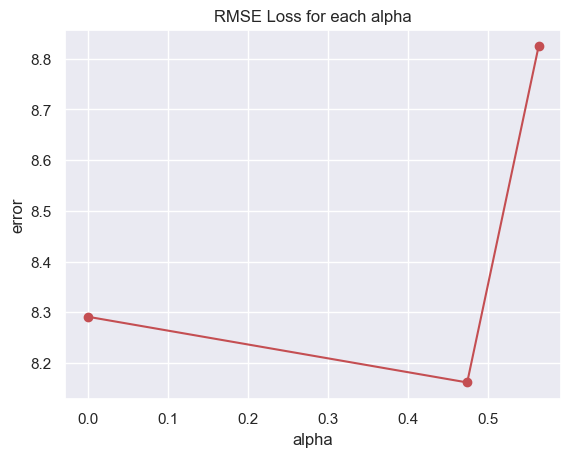

In [11]:
import pandas as pd 
import numpy as np 
from sklearn import datasets
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
from random import randrange
from math import *
import random
from functools import reduce
import copy
import csv
import sys
import seaborn as sns
from operator import itemgetter
sns.set()

class Node():
    def __init__(self, X: pd.DataFrame, Y: list, min_elements=None, depth=None, condition=None):
        self.X = X
        self.Y = Y 
                    
        self.left = None
        self.right = None
        
        self.features = list(self.X.columns)
        self.min_elements = min_elements

        self.depth = depth if depth else 0
        self.condition = condition if condition else ""
        
        if len(Y) != 0:
            self.RSS = np.sum((Y - np.mean(Y)) ** 2) / len(Y)
        else:
            self.RSS = 0
    
    def get_leaf(self) -> int:
        if self.left == None and self.right == None:
            return 1
        return self.left.get_leaf() + self.right.get_leaf();
    
    def get_RSS(self) -> int:
        if self.left == None and self.right == None:
            return self.RSS
        return self.left.get_RSS() + self.right.get_RSS();
    
    def predict(self, X : pd.DataFrame) -> float:
        if self.left == None and self.right == None:
            return round(np.mean(self.Y), 3)
        
        left = self.left
        right = self.right
        
        condition = left.condition.split()
        feature, sign, number = condition[0], condition[1], float(condition[2])
        
        if sign == '<=':
            if X[feature] <= number:
                return left.predict(X)
            return right.predict(X)
        if sign == '==':
            if X[feature] == number:
                return left.predict(X)
            return right.predict(X)

    
    def findCut(self) -> tuple:
        data = self.X.copy()
        data['Y'] = self.Y

        RSS_MIN = self.RSS

        final_feature = None
        final_v = None

        for feature in self.features:
            X = data.sort_values(feature)
            
            if str(feature) in ['cylinders', 'origin', 'model_year']:
                cuts = X[feature].unique()
            else:
                cuts = np.convolve(X[feature], np.ones(2), 'valid') / 2    
                
            for v in cuts:
                leftY = X[X[feature] < v]['Y'].values
                rightY = X[X[feature] >= v]['Y'].values
                
                if len(leftY) != 0:
                    leftMean = np.mean(leftY)
                else:
                    leftMean = 0
                    
                if len(rightY) != 0:
                    rightMean = np.mean(rightY)
                else:
                    rightMean = 0
                    
                resLeft = leftY - leftMean 
                resRight = rightY - rightMean
                                
                RSS_TMP = (np.sum(resLeft ** 2) + np.sum(resRight ** 2)) / (len(resLeft) + len(resRight))
                         
                if RSS_TMP < RSS_MIN:
                    final_feature = feature
                    final_v = v

                    RSS_MIN = RSS_TMP

        return (final_feature, final_v)

    def createTree(self):
        data = self.X.copy()
        data['Y'] = self.Y

        if len(self.Y) > self.min_elements and self.RSS != 0:

            final_feature, final_v = self.findCut()

            if final_feature is not None:                
                if final_feature in ['cylinders', 'origin', 'model_year']:
                    leftData = data[data[final_feature] == final_v].copy()
                    rightData = data[data[final_feature] != final_v].copy()
                    text1 = "=="
                    text2 = "!="
                else:
                    leftData = data[data[final_feature] <= final_v].copy()
                    rightData = data[data[final_feature] > final_v].copy()
                    text1 = "<="
                    text2 = ">"
                
                left = Node(
                    leftData[self.features],
                    leftData['Y'].values.tolist(),
                    depth=self.depth + 1, 
                    min_elements=self.min_elements, 
                    condition=f"{final_feature} {text1} {round(final_v, 3)}"
                    )

                self.left = left 
                self.left.createTree()

                right = Node(
                    rightData[self.features],
                    rightData['Y'].values.tolist(), 
                    depth=self.depth + 1, 
                    min_elements=self.min_elements,
                    condition=f"{final_feature} {text2} {round(final_v, 3)}"
                    )

                self.right = right
                self.right.createTree()
                
    def printTree(self):
        const = int(self.depth * 2 ** 1.5)
        spaces = "*" * const
        
        if self.condition == '':
            print("Root")
        else:
            print(f"@{spaces} Condition: {self.condition}")
        
        print(f"{' ' * const}   | Prediction: {round(np.mean(self.Y), 3)}")   
        print(f"{' ' * const}   | RSS: {round(self.RSS, 2)}")
        print(f"{' ' * const}   | Number of nodes: {len(self.Y)}")
        
        if self.left is not None: 
            self.left.printTree()
            self.right.printTree()

def getMinimumNode(node : Node, cost_root, isRoot = False):
    if node.left != None and node.right != None:
        (a_node, a_cost) = getMinimumNode(node.left, cost_root, False)
        (b_node, b_cost) = getMinimumNode(node.right, cost_root, False)
        
        g_ti = ( cost_root - node.RSS ) / (node.get_leaf() - 1)
        
        if a_cost < 0:
            a_cost = cost_root + 1
        if b_cost < 0:
            b_cost = cost_root + 1
            
        if isRoot == False:
            minim = min(g_ti, a_cost, b_cost)
        else:
            minim = min(a_cost, b_cost)
                
        if minim == g_ti:
            return node, g_ti

        if minim == a_cost:
            return a_node, a_cost

        if minim == b_cost:
            return b_node, b_cost
    else:
        leaf = node.get_leaf()
        
        if leaf == 1:
            return node, cost_root + 1
        
        g_ti = ( cost_root - node.RSS ) / (leaf - 1)
        return node, g_ti
    
def cutNode(root : Node, target : Node):
    if root.Y == target.Y:
        root.left= None
        root.right = None
        
        return True;
    else:
        if root.left != None and root.right != None:
            a = cutNode(root.left, target)
            if a == False:
                b = cutNode(root.right, target)
        else:
            return False
    return a or b
    
def AlphaPrunning(root : Node):
    forest = [(root, 0)]
    
    while root.get_leaf() > 2:
        node, alpha = getMinimumNode(root, root.RSS, True)
        new_tree = copy.deepcopy(root);
        
        if root.RSS <= alpha:
            break
        
        cutNode(new_tree, node)

        forest.append((new_tree, alpha))

        root = new_tree;
    
    return forest
    
def getDataSet(dataNumber):
    if dataNumber == 1:
        DATASET_NAME = "winequality-red.csv"
        CLASS = "CLASS"

        f_in = open(DATASET_NAME, 'r')
        csv_reader = csv.reader(f_in, delimiter=";")
        row = next(csv_reader)

        attributeNames = row[:-1]
        attributeNames = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides',
                        'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']
        
        examples = []
        classes = []

        for row in csv_reader:
            *attributes, label = row
            
            attributes = [float(i) for i in attributes]
            
            classes.append(float(label))
            example = dict(zip(attributeNames, attributes))
            examples.append(example)

        f_in.close()

        return classes, attributeNames, examples
    if dataNumber == 2:
        DATASET_NAME = "auto-mpg.data"
        CLASS = "*MPG (miles per gallon)"
        
        f_in = open(DATASET_NAME, 'r')
        csv_reader = csv.reader(f_in, delimiter="\t", skipinitialspace=True)

        examples = []
        full_examples_l = []
        classes = list()

        ok = True
        for row in csv_reader:    
            *attributes, car_name = row
            attributes = str(*attributes).split()
            
            attributes = [float(i) if i != '?' else '?' for i in attributes]
            label = attributes[0]
            attributes = attributes[1:]
            
            if ok == True:
                ok = False
                attributeNames = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin']

            example = dict(zip(attributeNames, attributes))
            full_example = dict(zip(attributeNames, attributes))
            full_example[CLASS] = label
            
            if example["horsepower"] != '?':
                classes.append(label)
                examples.append(example)
                full_examples_l.append(full_example)

        f_in.close()

        return classes, attributeNames, examples
    
# def cross_validation_split(dataFrame, folds=3):
#     data = dataFrame.copy()
#     data = data.sample(frac = 1).reset_index(drop = True)
    
#     folds_list = list()
#     fold_size = int(len(data) / folds)
    
#     for i in range(folds):
#         fold = data.iloc[:fold_size]
#         data.drop(data.head(fold_size).index, inplace=True)
        
#         fold = fold.reset_index()
#         folds_list.append(fold)

#     return folds_list

def split_dataset(X, Y, attributes, train=.8):
    X['Y'] = Y
    attributes.append('Y')
    
    procent = int(len(X.index) * 0.8);
    
    X_train = X.iloc[:procent]
    X.drop(X.head(procent).index, inplace=True)
    
    X_test = X.reset_index()
    
    Y_train = X_train['Y'].values.tolist()
    Y_test = X_test['Y'].values.tolist()
    
    attributes.remove('Y')
    X_train = X_train[attributes]
    X_test = X_test[attributes]
    
    return X_train, Y_train, X_test, Y_test

def show_alpha_trees(forest):
    for (tree, alpha) in forest:
        print("ALPHA =", alpha)
        print("COPAC =")
        tree.printTree()

def problema3():
    for i in range(1,3):
        print()
        if i == 1:
            print("WINEQUALITY-RED")
        else:
            print("AUTO-MPG")
        print()
        
        classes, attributes, X = getDataSet(i)

        X = np.array(X)
        Y = classes
        
        data = {}

        for attribute in attributes:
            data[attribute] = [X[0][attribute]]

        for ex in X[1:]:
            for attribute in attributes:
                data[attribute].append(ex[attribute])

        X = pd.DataFrame.from_dict(data)
        print(X)
        
        if i == 2:
            fig = plt.figure(figsize=(6, 5))
            plt.xlabel("x (feature)")
            plt.ylabel("y (output)")
            plt.title("HORSEPOWER")
            plt.plot(X['horsepower'], Y, 'co')
            plt.show()

            fig = plt.figure(figsize=(6, 5))
            plt.xlabel("x (feature)")
            plt.ylabel("y (output)")
            plt.title("WEIGHT")
            plt.plot(X['weight'], Y, 'mo')
            plt.show()

            fig = plt.figure(figsize=(6, 5))
            plt.xlabel("x (feature)")
            plt.ylabel("y (output)")
            plt.title("ACCELERATION")
            plt.plot(X['acceleration'], Y, 'bo')
            plt.show()

            fig = plt.figure(figsize=(6, 5))
            plt.xlabel("x (feature)")
            plt.ylabel("y (output)")
            plt.title("DISPLACEMENT")
            plt.plot(X['displacement'], Y, 'yo')
            plt.show()

            fig = plt.figure(figsize=(6, 5))
            plt.xlabel("x (feature)")
            plt.ylabel("y (output)")
            plt.title("CYLINDERS")
            plt.plot(X['cylinders'], Y, 'go')
            plt.show()

            fig = plt.figure(figsize=(6, 5))
            plt.xlabel("x (feature)")
            plt.ylabel("y (output)")
            plt.title("ORIGIN")
            plt.plot(X['origin'], Y, 'ro')
            plt.show()

            fig = plt.figure(figsize=(6, 5))
            plt.xlabel("x (feature)")
            plt.ylabel("y (output)")
            plt.title("MODEL YEAR")
            plt.plot(X['model_year'], Y, 'mo')
            plt.show()

        if i == 1:
            fig = plt.figure(figsize=(6, 5))
            plt.xlabel("x (feature)")
            plt.ylabel("y (output)")
            plt.title("fixed acidity")
            plt.plot(X['fixed_acidity'], Y, 'co')
            plt.show()

            fig = plt.figure(figsize=(6, 5))
            plt.xlabel("x (feature)")
            plt.ylabel("y (output)")
            plt.title("volatile acidity")
            plt.plot(X['volatile_acidity'], Y, 'mo')
            plt.show()

            fig = plt.figure(figsize=(6, 5))
            plt.xlabel("x (feature)")
            plt.ylabel("y (output)")
            plt.title("citric acid")
            plt.plot(X['citric_acid'], Y, 'bo')
            plt.show()

            fig = plt.figure(figsize=(6, 5))
            plt.xlabel("x (feature)")
            plt.ylabel("y (output)")
            plt.title("residual sugar")
            plt.plot(X['residual_sugar'], Y, 'yo')
            plt.show()

            fig = plt.figure(figsize=(6, 5))
            plt.xlabel("x (feature)")
            plt.ylabel("y (output)")
            plt.title("chlorides")
            plt.plot(X['chlorides'], Y, 'go')
            plt.show()

            fig = plt.figure(figsize=(6, 5))
            plt.xlabel("x (feature)")
            plt.ylabel("y (output)")
            plt.title("free sulfur dioxide")
            plt.plot(X['free_sulfur_dioxide'], Y, 'ro')
            plt.show()

            fig = plt.figure(figsize=(6, 5))
            plt.xlabel("x (feature)")
            plt.ylabel("y (output)")
            plt.title("total sulfur dioxide")
            plt.plot(X['total_sulfur_dioxide'], Y, 'mo')
            plt.show()
            
            fig = plt.figure(figsize=(6, 5))
            plt.xlabel("x (feature)")
            plt.ylabel("y (output)")
            plt.title("density")
            plt.plot(X['density'], Y, 'ro')
            plt.show()
            
            fig = plt.figure(figsize=(6, 5))
            plt.xlabel("x (feature)")
            plt.ylabel("y (output)")
            plt.title("pH")
            plt.plot(X['pH'], Y, 'bo')
            plt.show()
            
            fig = plt.figure(figsize=(6, 5))
            plt.xlabel("x (feature)")
            plt.ylabel("y (output)")
            plt.title("sulphates")
            plt.plot(X['sulphates'], Y, 'yo')
            plt.show()
            
            fig = plt.figure(figsize=(6, 5))
            plt.xlabel("x (feature)")
            plt.ylabel("y (output)")
            plt.title("alcohol")
            plt.plot(X['alcohol'], Y, 'go')
            plt.show()
            
        X_train, Y_train, X_test, Y_test = split_dataset(X, Y, attributes)

        root = Node(X_train, Y_train, min_elements=5)

        root.createTree()

        print("ROOT")

        root.printTree()

        print()
        forest = AlphaPrunning(root)

        saved_alpha = 0
        saved_tree = None
        SYS_MAX_VALUE = 9223372036854775807
        RSS = SYS_MAX_VALUE
        saved_y_hat = None
        
        errors_list = []
        alpha_list = []
                
        for (tree, alpha) in forest:
            y_hat = []
            for index, row in X_test.iterrows():
                y_hat.append(tree.predict(row))

            if tree.get_RSS() < RSS:
                RSS = tree.get_RSS()
                saved_alpha = alpha
                saved_tree = tree
                saved_y_hat = y_hat

            Y_HAT = np.array(y_hat)
            errors_list.append(sqrt(np.mean(np.square(Y_test - Y_HAT))))
            alpha_list.append(alpha)
        
        Y_test = np.array(Y_test)
        saved_y_hat = np.array(saved_y_hat)
        
        RMSE = sqrt(np.mean(np.square(Y_test - saved_y_hat)))
        print("RMSE FOR THE TREE CHOSE BY MIN RSS =", RMSE)
    
        fig, ax1 = plt.subplots(1,1);

        print("ALPHA LIST", alpha_list)
        ax1.plot(alpha_list, errors_list, 'ro-')
        ax1.set_ylabel("error")
        ax1.set_title("RMSE Loss for each alpha")
        ax1.set_xlabel("alpha")
    
        # Vezi arborii obtinuti si valorile alpha.
        #show_alpha_trees(forest)
    
problema3()        
        
#     K-FOLD ...
#     folds = cross_validation_split(X, 10)
#     for fold in folds:
#         X = fold[attributes]
#         Y = fold['Y'].values.tolist()
#        
#         Y_hat = []
#         for index, row in X.iterrows():
#             Y_hat.append(root.predict(row))
#    
#         print(Y_hat, Y)
#